In [263]:
# Import general libraries (needed for functions)
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Import the RB Functions
import qiskit.ignis.verification.randomized_benchmarking as rb

# Import Qiskit classes 
import qiskit
from qiskit import assemble, transpile
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error

# Import Backends
from quantuminspire.qiskit import QI

# Import utils
import sys 
sys.path.append('..')
import utils as u

In [22]:
u.set_auth('../credentials/auth.json')

In [23]:
QI.backends()

[<QuantumInspireBackend('Spin-2')>,
 <QuantumInspireBackend('Starmon-5')>,
 <QuantumInspireBackend('QX-34-L')>,
 <QuantumInspireBackend('QX single-node simulator')>]

In [266]:
# Generate RB circuits (5Q RB)

# number of qubits
nQ = 5
nseeds = 5
nCliffs = np.arange(1,200,20)
# rb_pattern = [[0, 2], [1], [3], [4]]
rb_pattern = [[0], [1], [2], [3], [4]]
length_multiplier = [3, 3, 3, 3, 3]

rb_opts = {}
rb_opts['length_vector'] = nCliffs
rb_opts['nseeds'] = nseeds
rb_opts['rb_pattern'] = rb_pattern
rb_opts['length_multiplier'] = length_multiplier
rb_circs, xdata = rb.randomized_benchmarking_seq(**rb_opts)

In [267]:
# Create a new circuit without the measurement
qregs = rb_circs[0][-1].qregs
cregs = rb_circs[0][-1].cregs
qc = qiskit.QuantumCircuit(*qregs, *cregs)
for i in rb_circs[0][-1][0:-nQ]:
    qc.data.append(i)
    
#The Unitary is an identity (with a global phase)
backend = qiskit.Aer.get_backend('unitary_simulator')
basis_gates = ['rx', 'ry'] 
job = qiskit.execute(qc, backend=backend, basis_gates=basis_gates)
print(np.around(job.result().get_unitary(), 3))

[[-0.707+0.707j -0.   +0.j    -0.   +0.j    ... -0.   +0.j
  -0.   -0.j    -0.   +0.j   ]
 [-0.   +0.j    -0.707+0.707j -0.   -0.j    ... -0.   -0.j
   0.   -0.j    -0.   +0.j   ]
 [-0.   -0.j     0.   -0.j    -0.707+0.707j ...  0.   -0.j
  -0.   +0.j    -0.   -0.j   ]
 ...
 [-0.   -0.j    -0.   -0.j     0.   +0.j    ... -0.707+0.707j
  -0.   -0.j    -0.   +0.j   ]
 [-0.   -0.j    -0.   +0.j     0.   +0.j    ...  0.   -0.j
  -0.707+0.707j -0.   +0.j   ]
 [-0.   -0.j     0.   -0.j     0.   +0.j    ... -0.   -0.j
  -0.   +0.j    -0.707+0.707j]]


In [268]:
# Run on a noisy simulator
noise_model = NoiseModel()

# Depolarizing error on the gates
p1Q = 0.002
p2Q = 0.01

noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'rx')
noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'ry')
# noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cz')

In [269]:
# Create the RB fitter
backend = qiskit.Aer.get_backend('qasm_simulator')
# backend = QI.get_backend('Starmon-5')
basis_gates = ['rx', 'ry'] 
shots = 200
result_list = []
transpile_list = []
import time
for rb_seed,rb_circ_seed in enumerate(rb_circs):
    print('Compiling seed %d'%rb_seed)
    rb_circ_transpile = qiskit.transpile(rb_circ_seed, basis_gates=basis_gates)
    print('Simulating seed %d'%rb_seed)
    job = qiskit.execute(rb_circ_transpile, shots=shots, noise_model=noise_model, backend=backend, backend_options={'max_parallel_experiments': 0})
    result_list.append(job.result())
    transpile_list.append(rb_circ_transpile)
print("Finished Simulating")

Compiling seed 0
Simulating seed 0
Compiling seed 1
Simulating seed 1
Compiling seed 2
Simulating seed 2
Compiling seed 3
Simulating seed 3
Compiling seed 4
Simulating seed 4
Finished Simulating


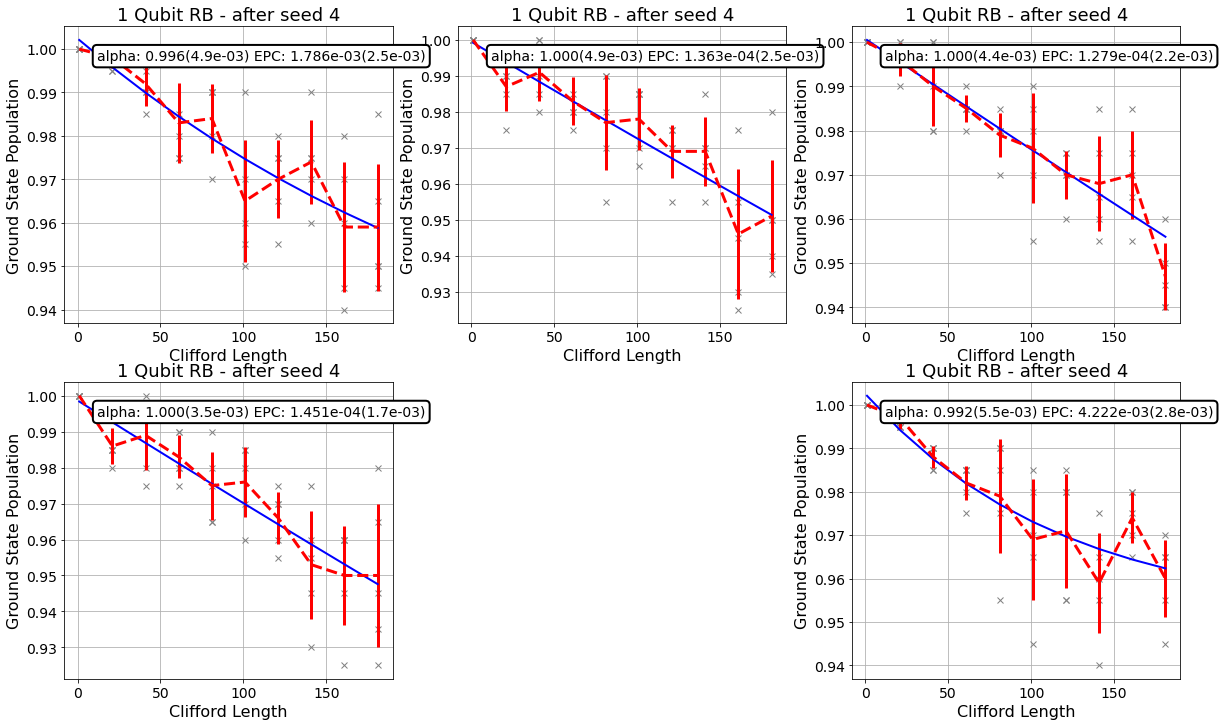

In [282]:
rbfit = rb.fitters.RBFitter(result_list[0], xdata, rb_opts['rb_pattern'])

for seed_num, data in enumerate(result_list):#range(1,len(result_list)):
    plt.figure(figsize=(20, 12))
    axis = [plt.subplot(231), plt.subplot(232), plt.subplot(233), plt.subplot(234), plt.subplot(236)]

    # Add another seed to the data
    rbfit.add_data([data])

    for i in range(5):
        pattern_ind = i

        # Plot the essence by calling plot_rb_data
        rbfit.plot_rb_data(pattern_ind, ax=axis[i], add_label=True, show_plt=False)

        # Add title and label
        axis[i].set_title('%d Qubit RB - after seed %d'%(len(rb_opts['rb_pattern'][i]), seed_num), fontsize=18)

    # Display
    display.display(plt.gcf())

    # Clear display after each seed and close
    display.clear_output(wait=True)
    time.sleep(1.0)
    plt.close()

In [284]:
#Count the number of single and 2Q gates in the 2Q Cliffords
gates_per_cliff = rb.rb_utils.gates_per_clifford(transpile_list,xdata[0],basis_gates,rb_opts['rb_pattern'][0])
for basis_gate in basis_gates:
    print("Number of %s gates per Clifford: %f "%(basis_gate ,
                                                  np.mean([gates_per_cliff[0][basis_gate],
                                                           gates_per_cliff[1][basis_gate]])))

KeyError: 1

In [297]:
# count the number of single and 2Q gates in the 2Q Cliffords
qubits = rb_opts['rb_pattern'][0]

gate_per_cliff = rb.rb_utils.gates_per_clifford(
    transpiled_circuits_list=transpile_list,
    clifford_lengths=xdata[0],
    basis=basis_gates,
    qubits=qubits)


print(gate_per_cliff)

for basis_gate in basis_gates:
    print("Number of %s gates per Clifford: %f"%(
        basis_gate,
        np.mean([gate_per_cliff[qubit][basis_gate] for qubit in qubits])))

{0: {'rx': 0.996304347826087, 'ry': 0.8378260869565217}}
Number of rx gates per Clifford: 0.996304
Number of ry gates per Clifford: 0.837826


In [298]:

epgs = rb.rb_utils.calculate_1q_epg(gate_per_cliff=gate_per_cliff, epc_1q=1.786e-3, qubit=0)
pprint.pprint(epgs)

QiskitError: 'Invalid basis set is given. Use `u1`, `u2`, `u3` for basis gates.'

In [292]:
# Test on spin-2

qc = QuantumCircuit(2, 2)
qc.x(0)
qc.measure(0, 0)
qc.measure(1, 1)

qc.draw()

┌───┐┌─┐
q_0: ┤ X ├┤M├
     └┬─┬┘└╥┘
q_1: ─┤M├──╫─
      └╥┘  ║ 
c: 2/══╩═══╩═
       1   0

In [293]:
backend = QI.get_backend('Spin-2')
shots = 256
job = qiskit.execute(qc, shots=shots, backend=backend, backend_options={'max_parallel_experiments': 0})

In [294]:
job.status()

<JobStatus.QUEUED: 'job is queued'>

In [295]:
# Test on simulator
qc = QuantumCircuit(2, 2)
qc.x(0)
qc.measure(0, 0)
qc.measure(1, 1)

qc.draw()

backend = QI.get_backend('Starmon-5')
shots = 256
job = qiskit.execute(qc, shots=shots, backend=backend, backend_options={'max_parallel_experiments': 0})

ApiError: Job with name circuit-5185850 not created: <Error: 403 Forbidden>
    detail: "You already have 20 jobs queued on this backend. Please wait for those jobs to finish or cancel a job."

In [ ]:
job.status()

In [ ]:
(job.result()).get_counts()

In [ ]:
(job.result()).get_counts() # results from 01 10

In [299]:
print(xdata)

[[  1  21  41  61  81 101 121 141 161 181]
 [  1  21  41  61  81 101 121 141 161 181]
 [  1  21  41  61  81 101 121 141 161 181]
 [  1  21  41  61  81 101 121 141 161 181]
 [  1  21  41  61  81 101 121 141 161 181]]
